In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import io
import os
import math
from sklearn.metrics import silhouette_samples,silhouette_score
from sklearn import preprocessing
from scipy.spatial import distance
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
import random 
random.seed(33)

In [2]:
listings = pd.read_csv('../Data/listings_clean.csv', index_col=0)

In [3]:
numerical_features = ['latitude', 'longitude', 'accommodates', 'bathrooms','bedrooms', 'beds']

In [4]:
boolean_features = ['instant_bookable', 'is_business_travel_ready']

In [5]:
categorical_features = ['neighbourhood_cleansed', 'property_type', 'bed_type']
listings_categorical = pd.get_dummies(listings[categorical_features], columns=categorical_features, 
                            prefix=["Neigh", "Property", "Bed"])

In [6]:
listingsCluster = pd.concat([listings[numerical_features],listings[categorical_features],listings[boolean_features]], axis=1)

In [7]:
listingsCluster.head()

,latitude,longitude,accommodates,bathrooms,bedrooms,beds,neighbourhood_cleansed,property_type,bed_type,instant_bookable,is_business_travel_ready
id,,,,,,,,,,,
18628,40.424715,-3.698638,2,1.0,0.0,1.0,Justicia,Apartment,Pull-out Sofa,1,0
19864,40.413418,-3.706838,2,1.0,0.0,1.0,Embajadores,Apartment,Pull-out Sofa,1,0
21512,40.424920,-3.713446,2,1.0,0.0,1.0,Argüelles,Apartment,Pull-out Sofa,0,0
23021,40.423417,-3.712456,10,3.0,4.0,5.0,Argüelles,Apartment,Real Bed,0,0
24805,40.422022,-3.703954,3,1.0,0.0,2.0,Universidad,Apartment,Real Bed,0,0


In [8]:
listingsCluster.isnull().sum()

latitude                    0
longitude                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
neighbourhood_cleansed      0
property_type               0
bed_type                    0
instant_bookable            0
is_business_travel_ready    0
dtype: int64

In [9]:
to_categorical = categorical_features + boolean_features
indCatColumns = [listingsCluster.columns.get_loc(col) for col in to_categorical]

In [10]:
from sklearn.preprocessing import RobustScaler
RS = RobustScaler()

In [11]:
listingsCluster[numerical_features] = RS.fit_transform(listingsCluster[numerical_features])

In [12]:
listingsCluster.describe()

,latitude,longitude,accommodates,bathrooms,bedrooms,beds,instant_bookable,is_business_travel_ready
count,8.586000e+03,8.586000e+03,8586.000000,8586.000000,8586.000000,8586.000000,8586.000000,8586.000000
mean,1.526813e-01,3.135931e-01,0.066562,0.248777,0.479385,0.201025,0.556138,0.063359
std,1.118500e+00,1.670191e+00,0.966366,0.512864,0.957383,0.766550,0.496867,0.243622
min,-5.753218e+00,-1.201677e+01,-1.500000,-1.000000,-1.000000,-0.500000,0.000000,0.000000
25%,-4.771182e-01,-4.703298e-01,-0.500000,0.000000,0.000000,-0.500000,0.000000,0.000000
50%,2.397762e-13,-1.997035e-14,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,5.228818e-01,5.296702e-01,0.500000,0.000000,1.000000,0.500000,1.000000,0.000000
max,1.261458e+01,1.425931e+01,6.000000,5.000000,9.000000,7.500000,1.000000,1.000000


In [13]:
! pip install --upgrade kmodes

Requirement already up-to-date: kmodes in /home/dsc/anaconda3/lib/python3.5/site-packages (0.9)
Requirement not upgraded as not directly required: scipy>=0.13.3 in /home/dsc/anaconda3/lib/python3.5/site-packages (from kmodes) (1.0.1)
Requirement not upgraded as not directly required: scikit-learn<0.20.0,>=0.19.0 in /home/dsc/anaconda3/lib/python3.5/site-packages (from kmodes) (0.19.1)
Requirement not upgraded as not directly required: numpy>=1.10.4 in /home/dsc/anaconda3/lib/python3.5/site-packages (from kmodes) (1.14.3)


In [14]:
from kmodes.kprototypes import KPrototypes

In [15]:
for cat_col in categorical_features:
    listingsCluster[cat_col] = preprocessing.LabelEncoder().fit_transform(listingsCluster[cat_col])

In [16]:
X = listingsCluster.values

In [17]:
def distance_dissim(X,Y,gamma,categorical):
    no_categorical = [i for i in range(len(X)) if i not in categorical]
    Xnum = np.asanyarray([X[ii] for ii in no_categorical]).astype(np.float64)
    Ynum = np.asanyarray([Y[ii] for ii in no_categorical]).astype(np.float64)
    Xcat = np.asanyarray([X[ii] for ii in categorical])
    Ycat = np.asanyarray([Y[ii] for ii in categorical])
    
    distance_dissim = distance.euclidean(Xnum, Ynum) + gamma * np.sum(Xcat != Ycat)
    
    return distance_dissim

In [18]:
meandist=[]
clusters = range(1,10)

for k in clusters:
    model = KPrototypes(n_clusters=k, init='Huang', n_init=1, verbose=2)
    model_fit = model.fit(X, categorical = indCatColumns)
    clusassign= model_fit.predict(X, categorical = indCatColumns)
    centroids = list()
    for i in range(k):
        centroids.append(list())
        centroids[i] = np.append(model_fit.cluster_centroids_[0][i], model_fit.cluster_centroids_[1][i])
    meandist.append(sum(np.min(cdist(X,centroids, metric=lambda X,Y: distance_dissim(X,Y,gamma = model_fit.gamma,categorical = indCatColumns)),axis=1))/listingsCluster.shape[0])

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 0, ncost: 64617.31337055105
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 699, ncost: 50944.90928473061
Run: 1, iteration: 2/100, moves: 345, ncost: 50634.476075384475
Run: 1, iteration: 3/100, moves: 263, ncost: 50332.43533432491
Run: 1, iteration: 4/100, moves: 219, ncost: 50005.58038436123
Run: 1, iteration: 5/100, moves: 138, ncost: 49792.049015464734
Run: 1, iteration: 6/100, moves: 77, ncost: 49722.1029087929
Run: 1, iteration: 7/100, moves: 31, ncost: 49710.15755629834
Run: 1, iteration: 8/100, moves: 3, ncost: 49710.04154726069
Run: 1, iteration: 9/100, moves: 0, ncost: 49710.04154726069
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 2188, ncost: 39825.80954729527
Run: 1, iteration: 2/100, moves: 374, ncost: 39662.097246759615
Run: 1, i

Run: 1, iteration: 21/100, moves: 25, ncost: 25062.288613751876
Run: 1, iteration: 22/100, moves: 14, ncost: 25060.418900036108
Run: 1, iteration: 23/100, moves: 5, ncost: 25060.060891498
Run: 1, iteration: 24/100, moves: 8, ncost: 25058.478932617345
Run: 1, iteration: 25/100, moves: 18, ncost: 25055.688528334005
Run: 1, iteration: 26/100, moves: 19, ncost: 25051.98031714603
Run: 1, iteration: 27/100, moves: 25, ncost: 25049.721474042635
Run: 1, iteration: 28/100, moves: 5, ncost: 25049.55608464471
Run: 1, iteration: 29/100, moves: 8, ncost: 25046.42289164045
Run: 1, iteration: 30/100, moves: 11, ncost: 25044.294188832344
Run: 1, iteration: 31/100, moves: 4, ncost: 25044.140839973978
Run: 1, iteration: 32/100, moves: 0, ncost: 25044.140839973978


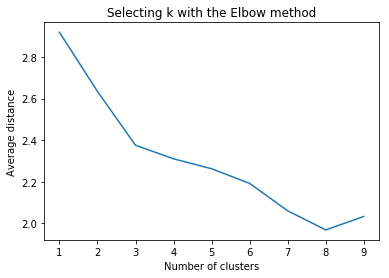

In [19]:
plt.plot(clusters,meandist)
plt.xlabel("Number of clusters")
plt.ylabel("Average distance")
plt.title("Selecting k with the Elbow method")
plt.show()

In [20]:
#According to the Elbow method, we could consider 3 clusters and maybe 5 and 8 clusters

In [21]:
model3 = KPrototypes(n_clusters=3, init='Huang', n_init=1, verbose=2)
model_fit3 = model3.fit(X, categorical = indCatColumns)
clusassign3= model_fit3.predict(X, categorical = indCatColumns)
listings['Cluster3'] = model_fit3.labels_

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 4270, ncost: 44207.408357530236
Run: 1, iteration: 2/100, moves: 1882, ncost: 40079.71924423144
Run: 1, iteration: 3/100, moves: 422, ncost: 39675.403030112604
Run: 1, iteration: 4/100, moves: 88, ncost: 39652.8328628479
Run: 1, iteration: 5/100, moves: 15, ncost: 39652.244259453655
Run: 1, iteration: 6/100, moves: 3, ncost: 39652.220336804174
Run: 1, iteration: 7/100, moves: 0, ncost: 39652.220336804174


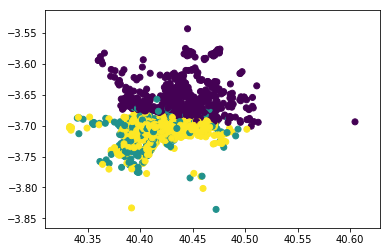

In [22]:
plt.scatter(listings['latitude'], listings['longitude'], c = model_fit3.labels_.astype(np.float))
plt.show()

In [23]:
model5 = KPrototypes(n_clusters=5, init='Huang', n_init=1, verbose=2)
model_fit5 = model5.fit(X, categorical = indCatColumns)
clusassign5= model_fit5.predict(X, categorical = indCatColumns)
listings['Cluster5'] = model_fit5.labels_

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 2185, ncost: 34643.76126119293
Run: 1, iteration: 2/100, moves: 718, ncost: 34422.40371086918
Run: 1, iteration: 3/100, moves: 317, ncost: 34369.05513975809
Run: 1, iteration: 4/100, moves: 269, ncost: 34320.43540537699
Run: 1, iteration: 5/100, moves: 219, ncost: 34289.015030588205
Run: 1, iteration: 6/100, moves: 126, ncost: 34277.38028456746
Run: 1, iteration: 7/100, moves: 111, ncost: 34269.665796468355
Run: 1, iteration: 8/100, moves: 75, ncost: 34265.13219860117
Run: 1, iteration: 9/100, moves: 59, ncost: 34261.91889835803
Run: 1, iteration: 10/100, moves: 67, ncost: 34258.533070856356
Run: 1, iteration: 11/100, moves: 39, ncost: 34257.02655498044
Run: 1, iteration: 12/100, moves: 47, ncost: 34254.81407802083
Run: 1, iteration: 13/100, moves: 48, ncost: 34252.45254117931
Run: 1, iteration: 14/100, moves: 33, ncost: 34251.827602657475
Run: 1, iteration: 15/100, moves: 2

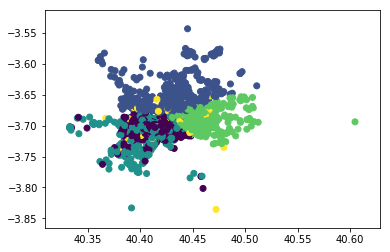

In [24]:
plt.scatter(listings['latitude'], listings['longitude'], c = model_fit5.labels_.astype(np.float))
plt.show()

In [25]:
model8 = KPrototypes(n_clusters=8, init='Huang', n_init=1, verbose=2)
model_fit8 = model8.fit(X, categorical = indCatColumns)
clusassign8= model_fit8.predict(X, categorical = indCatColumns)
listings['Cluster8'] = model_fit8.labels_

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 3136, ncost: 27758.985227577938
Run: 1, iteration: 2/100, moves: 1047, ncost: 26770.23462161185
Run: 1, iteration: 3/100, moves: 633, ncost: 26183.401012044164
Run: 1, iteration: 4/100, moves: 276, ncost: 26076.097710323025
Run: 1, iteration: 5/100, moves: 119, ncost: 26032.767863381432
Run: 1, iteration: 6/100, moves: 81, ncost: 26007.483348516158
Run: 1, iteration: 7/100, moves: 38, ncost: 26000.471804435372
Run: 1, iteration: 8/100, moves: 14, ncost: 25999.435533878062
Run: 1, iteration: 9/100, moves: 0, ncost: 25999.435533878062


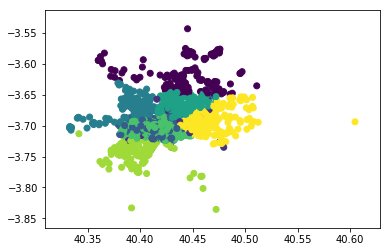

In [26]:
plt.scatter(listings['latitude'], listings['longitude'], c = model_fit8.labels_.astype(np.float))
plt.show()

In [27]:
labels = model_fit3.labels_
gamma = model_fit3.gamma
Silhoutte3 = silhouette_score(X, labels, metric= lambda X,Y: distance_dissim(X,Y,gamma = gamma,categorical = indCatColumns))
print(Silhoutte3)

0.27817359317123935


In [28]:
labels = model_fit5.labels_
gamma = model_fit5.gamma
Silhoutte5 = silhouette_score(X, labels, metric= lambda X,Y: distance_dissim(X,Y,gamma = gamma,categorical = indCatColumns))
print(Silhoutte5)

0.21581008536369814


In [29]:
labels = model_fit8.labels_
gamma = model_fit8.gamma
Silhoutte5 = silhouette_score(X, labels, metric= lambda X,Y: distance_dissim(X,Y,gamma = gamma,categorical = indCatColumns))
print(Silhoutte8)

NameError: name 'Silhoutte8' is not defined

In [ ]:
#The Silhoutte coefficient should be close to 1 if there is a good split between clusters, so it doesn't seem these are good clusters
#Even though, we test the stability of the clusters recalculating them with K=3 (highest coefficient)

In [ ]:
centroids = model_fit3.cluster_centroids_[0]
centroids_PCA = PCA(n_components=2).fit_transform(centroids)

In [ ]:
x_coord=list()
y_coord=list()
x_coord.append(list())
y_coord.append(list())
for i in range(0,3):
    x_coord[0].append(centroids_PCA[i][0])
    y_coord[0].append(centroids_PCA[i][1])

In [ ]:
for k in range(1,10):
    model = KPrototypes(n_clusters=3, init='Huang', n_init=1, verbose=False)
    model_fit = model.fit(X, categorical = indCatColumns)
    centroids = model_fit.cluster_centroids_[0]
    centroids_PCA = PCA(n_components=2).fit_transform(centroids)
    x_coord.append(list())
    y_coord.append(list())
    for i in range(0,3):
        x_coord[k].append(centroids_PCA[i][0])
        y_coord[k].append(centroids_PCA[i][1])

In [ ]:
plt.plot(x_coord[0],y_coord[0], 'ro',x_coord[1],y_coord[1], 'bo', x_coord[2],y_coord[2], 'yo', x_coord[3],y_coord[3], 'go', x_coord[4],y_coord[4], 'co', x_coord[5],y_coord[5], 'mo', x_coord[6],y_coord[6], 'ro', x_coord[7],y_coord[7], 'bo', x_coord[8],y_coord[8], 'go', x_coord[9],y_coord[9], 'go')
plt.show()

In [ ]:
x_coord

In [ ]:
#We can see that although the Silhouette coefficient is not high, the cluster centroids are stable 
#(at lest on the numerical variables),as we get almost the same ones after running the algorithm multiple times

In [ ]:
#We export them in order to study the clusters in other tool
listings.to_csv('../Data/listings_cluster.csv', index=False)